In [44]:

# ===================================================================
# CELL 1: Setup and Data Loading
# ===================================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import numpy as np
from scipy import stats
from scipy.stats import mannwhitneyu, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("="*70)
print("TFT DATA ANALYSIS - PERFORMANCE EVALUATION")
print("="*70)

# Load YOUR filtered dataset (already contains only your matches)
matches_df = pd.read_csv('tft_my_matches_only.csv')

print(f"\n✅ Dataset loaded successfully")
print(f"   File: tft_my_matches_only.csv")
print(f"   Rows: {len(matches_df)}")
print(f"   Columns: {len(matches_df.columns)}")

# Data Quality Assessment
print(f"\n" + "="*70)
print("DATA QUALITY ASSESSMENT")
print("="*70)
print(f"Dataset Shape: {matches_df.shape}")
print(f"\nMissing Values Check:")
missing = matches_df.isnull().sum()
missing_cols = missing[missing > 0]
if len(missing_cols) > 0:
    print(missing_cols)
else:
    print("✅ No missing values in dataset")

print(f"\nData Types:")
print(matches_df.dtypes)

# Verify this is YOUR data only
print(f"\n" + "="*70)
print("DATA VERIFICATION")
print("="*70)
print(f"Unique players (PUUIDs): {matches_df['puuid'].nunique()}")
print(f"Unique matches: {matches_df['match_id'].nunique()}")

if matches_df['puuid'].nunique() == 1:
    print(f"✅ Confirmed: Dataset contains only YOUR matches")
else:
    print(f"⚠️ Warning: Dataset contains multiple players")

# Store as your_games for compatibility
your_games = matches_df.copy()

print(f"\n" + "="*70)
print("BASIC STATISTICS")
print("="*70)
print(f"Total Games: {len(your_games)}")
print(f"Average Placement: {your_games['placement'].mean():.2f}")
print(f"Median Placement: {your_games['placement'].median():.1f}")
print(f"Win Rate: {your_games['win'].mean()*100:.1f}%")
print(f"Top 4 Rate: {your_games['top_4'].mean()*100:.1f}%")
print(f"Best Placement: {your_games['placement'].min()}")
print(f"Worst Placement: {your_games['placement'].max()}")
print("="*70)


TFT DATA ANALYSIS - PERFORMANCE EVALUATION

✅ Dataset loaded successfully
   File: tft_my_matches_only.csv
   Rows: 100
   Columns: 24

DATA QUALITY ASSESSMENT
Dataset Shape: (100, 24)

Missing Values Check:
skill_tree    75
dtype: int64

Data Types:
companion                   object
gold_left                    int64
last_round                   int64
level                        int64
missions                    object
placement                    int64
players_eliminated           int64
puuid                       object
riotIdGameName              object
riotIdTagline               object
time_eliminated            float64
total_damage_to_players      int64
traits                      object
units                       object
win                           bool
match_id                    object
game_datetime              float64
game_length                float64
game_version                object
tft_set_number               int64
tft_game_type               object
queue_id      

In [45]:
# ===================================================================
# CELL 2: Trait Extraction and Analysis
# ===================================================================

import ast

print("\n" + "="*70)
print("TRAIT ANALYSIS")
print("="*70)

def extract_traits(trait_string):
    """
    Extract trait names from trait string, assuming it's a string representation
    of a list of dictionaries, or a semi-colon separated string.
    Example 1: "[{'name': 'TFT16_Brawler', 'num_units': 2, 'style': 1}]" -> ["Brawler"]
    Example 2: "TFT16_Brawler(2); TFT16_Ionia(5)" -> ["Brawler", "Ionia"]
    """
    if pd.isna(trait_string) or not isinstance(trait_string, str):
        return []

    traits = []
    # Try parsing as a list of dictionaries
    try:
        # Convert single quotes to double quotes for valid JSON-like parsing
        # Some string representations might use single quotes, ast.literal_eval handles this.
        trait_data = ast.literal_eval(trait_string)
        if isinstance(trait_data, list):
            for item in trait_data:
                if isinstance(item, dict) and 'name' in item:
                    # Extract the actual trait name, removing 'TFTX_Trait_' or 'TFTX_' prefix
                    match = re.search(r'TFT\d+_(Trait_)?(\w+)', item['name'])
                    if match:
                        traits.append(match.group(2)) # Group 2 is the actual trait name
    except (ValueError, SyntaxError):
        # If it's not a list of dictionaries, try the original regex for semi-colon separated format
        # This handles cases like "TFT16_Brawler(2); TFT16_Ionia(5)"
        matches = re.findall(r'TFT\d+_(\w+)\(d+\)', trait_string)
        if matches:
            traits.extend(matches)
        else:
            # A final fallback for just trait names without tier info, e.g. "TFT16_Brawler"
            matches = re.findall(r'TFT\d+_(\w+)', trait_string)
            if matches:
                traits.extend(matches)

    return traits

# Extract traits
your_games['trait_list'] = your_games['traits'].apply(extract_traits)

# Count trait usage
all_traits = [trait for sublist in your_games['trait_list'] for trait in sublist]
trait_counts = Counter(all_traits)

print(f"\n✅ Extracted traits from {len(your_games)} matches")
print(f"   Total unique traits: {len(trait_counts)}")
print(f"   Most used traits:")

top_10_traits = [t[0] for t in trait_counts.most_common(10)]
for i, (trait, count) in enumerate(trait_counts.most_common(10), 1):
    usage_rate = count / len(your_games) * 100
    print(f"   {i:2d}. {trait:20s}: {count:3d} games ({usage_rate:5.1f}%)")

# Calculate trait performance
print(f"\n" + "="*70)
print("TRAIT PERFORMANCE ANALYSIS")
print("="*70)

trait_performance = []
# Only proceed if there are traits to analyze
if top_10_traits:
    for trait in top_10_traits:
        games_with = your_games[your_games['trait_list'].apply(lambda x: trait in x)]

        if len(games_with) >= 3:  # Minimum sample size
            trait_performance.append({
                'Trait': trait,
                'Games': len(games_with),
                'Usage %': len(games_with) / len(your_games) * 100,
                'Avg Placement': games_with['placement'].mean(),
                'Win Rate %': games_with['win'].mean() * 100,
                'Top 4 %': games_with['top_4'].mean() * 100
            })

# Add a check for empty trait_performance list before creating DataFrame
if trait_performance:
    trait_perf_df = pd.DataFrame(trait_performance).sort_values('Avg Placement')
    print("\nTop 10 Traits by Average Placement:")
    print(trait_perf_df.to_string(index=False))
else:
    print("⚠️ No traits found or not enough data to analyze trait performance.")
    trait_perf_df = pd.DataFrame(columns=['Trait', 'Games', 'Usage %', 'Avg Placement', 'Win Rate %', 'Top 4 %']) # Define an empty DataFrame with columns to prevent errors in subsequent cells


TRAIT ANALYSIS

✅ Extracted traits from 100 matches
   Total unique traits: 68
   Most used traits:
    1. Juggernaut          :  59 games ( 59.0%)
    2. Sorcerer            :  52 games ( 52.0%)
    3. Brawler             :  51 games ( 51.0%)
    4. Noxus               :  47 games ( 47.0%)
    5. Zaun                :  46 games ( 46.0%)
    6. Defender            :  37 games ( 37.0%)
    7. Warden              :  35 games ( 35.0%)
    8. Piltover            :  35 games ( 35.0%)
    9. Magus               :  30 games ( 30.0%)
   10. ShyvanaUnique       :  28 games ( 28.0%)

TRAIT PERFORMANCE ANALYSIS

Top 10 Traits by Average Placement:
        Trait  Games  Usage %  Avg Placement  Win Rate %   Top 4 %
ShyvanaUnique     28     28.0       3.785714   35.714286 57.142857
        Magus     30     30.0       4.500000   20.000000 43.333333
      Brawler     51     51.0       4.627451   21.568627 41.176471
         Zaun     46     46.0       4.652174   19.565217 41.304348
        Noxus     4

In [46]:
# ===================================================================
# CELL 3: Augment Analysis (Modified - Reference Data Only)
# ===================================================================

print("\n" + "="*70)
print("AUGMENT ANALYSIS")
print("="*70)

# Load the augment reference dataset
augments_reference_df = pd.read_csv('TFT-augments.csv')
print(f"✅ Loaded augment reference data: {len(augments_reference_df)} augments")

print("\n⚠️ Note: Augment data not available in collected match data")
print("   Analysis based on global statistics from TFT-augments.csv")

print("\n" + "="*70)
print("GLOBAL AUGMENT INSIGHTS")
print("="*70)

# Clean the data
augments_reference_df['Win Rate'] = augments_reference_df['Win Rate'] * 100

# Filter for augments with reasonable sample size
reliable_augments = augments_reference_df[augments_reference_df['Games Played'] >= 100].copy()
print(f"\nFiltered to {len(reliable_augments)} augments with ≥100 games for reliability")

# Top performers
print("\n🏆 Top 10 Augments by Win Rate (min 100 games):")
top_by_winrate = reliable_augments.nlargest(10, 'Win Rate')
print(top_by_winrate[['Augment Name', 'Win Rate', 'Average Placement', 'Games Played', 'Top 4']].to_string(index=False))

# Best average placement
print("\n📊 Top 10 Augments by Average Placement (min 100 games):")
top_by_placement = reliable_augments.nsmallest(10, 'Average Placement')
print(top_by_placement[['Augment Name', 'Average Placement', 'Win Rate', 'Games Played', 'Top 4']].to_string(index=False))

# Most popular augments
print("\n🎯 Most Popular Augments (by games played):")
most_popular = augments_reference_df.nlargest(10, 'Games Played')
print(most_popular[['Augment Name', 'Games Played', 'Win Rate', 'Average Placement']].to_string(index=False))

# Statistical insights
print("\n" + "="*70)
print("AUGMENT STATISTICS SUMMARY")
print("="*70)
print(f"  Total augments in database: {len(augments_reference_df)}")
print(f"  Average win rate: {augments_reference_df['Win Rate'].mean():.2f}%")
print(f"  Average placement: {augments_reference_df['Average Placement'].mean():.2f}")
print(f"  Median games played: {augments_reference_df['Games Played'].median():.0f}")
print(f"  Most played augment: {augments_reference_df.loc[augments_reference_df['Games Played'].idxmax(), 'Augment Name']}")
print(f"                      ({augments_reference_df['Games Played'].max()} games)")

# Recommendations based on data
print("\n" + "="*70)
print("AUGMENT RECOMMENDATIONS FOR FUTURE GAMES")
print("="*70)
print("\n💡 High-Impact Augments to Prioritize:")
high_impact = reliable_augments[
    (reliable_augments['Win Rate'] > 20) &
    (reliable_augments['Average Placement'] < 4.3)
].nlargest(5, 'Win Rate')
if len(high_impact) > 0:
    print(high_impact[['Augment Name', 'Win Rate', 'Average Placement']].to_string(index=False))
else:
    print("   None meet criteria (WR >20%, Avg Place <4.3)")

print("\n⚠️ Augments to Avoid:")
avoid = reliable_augments[
    (reliable_augments['Win Rate'] < 10) &
    (reliable_augments['Average Placement'] > 4.7)
].nsmallest(5, 'Win Rate')
if len(avoid) > 0:
    print(avoid[['Augment Name', 'Win Rate', 'Average Placement']].to_string(index=False))
else:
    print("   None meet criteria (WR <10%, Avg Place >4.7)")

# Store for export
aug_perf_df = reliable_augments

print("\n" + "="*70)
print("✅ Augment analysis complete (reference data only)")
print("="*70)


AUGMENT ANALYSIS
✅ Loaded augment reference data: 268 augments

⚠️ Note: Augment data not available in collected match data
   Analysis based on global statistics from TFT-augments.csv

GLOBAL AUGMENT INSIGHTS

Filtered to 139 augments with ≥100 games for reliability

🏆 Top 10 Augments by Win Rate (min 100 games):
       Augment Name  Win Rate  Average Placement  Games Played  Top 4
Ixtal Expeditionist      27.0               4.75           253   0.45
          Max Build      25.0               4.12           500   0.55
          Ascension      21.0               4.03           184   0.57
           Firesale      20.0               4.24           281   0.54
    The Trait Tree+      19.0               4.36           188   0.54
      Tiniest Titan      19.0               4.04           172   0.59
         Invested++      19.0               4.45           134   0.49
       Urf's Gambit      19.0               4.30           115   0.52
    Spreading Roots      18.0               4.33     


PERFORMANCE TREND ANALYSIS & VISUALIZATIONS

Performance Phase Distribution:
  Strong  :  40 games ( 40.0%)
  Average :  19 games ( 19.0%)
  Weak    :  41 games ( 41.0%)

✅ Saved: tft_performance_dashboard.png (high resolution)


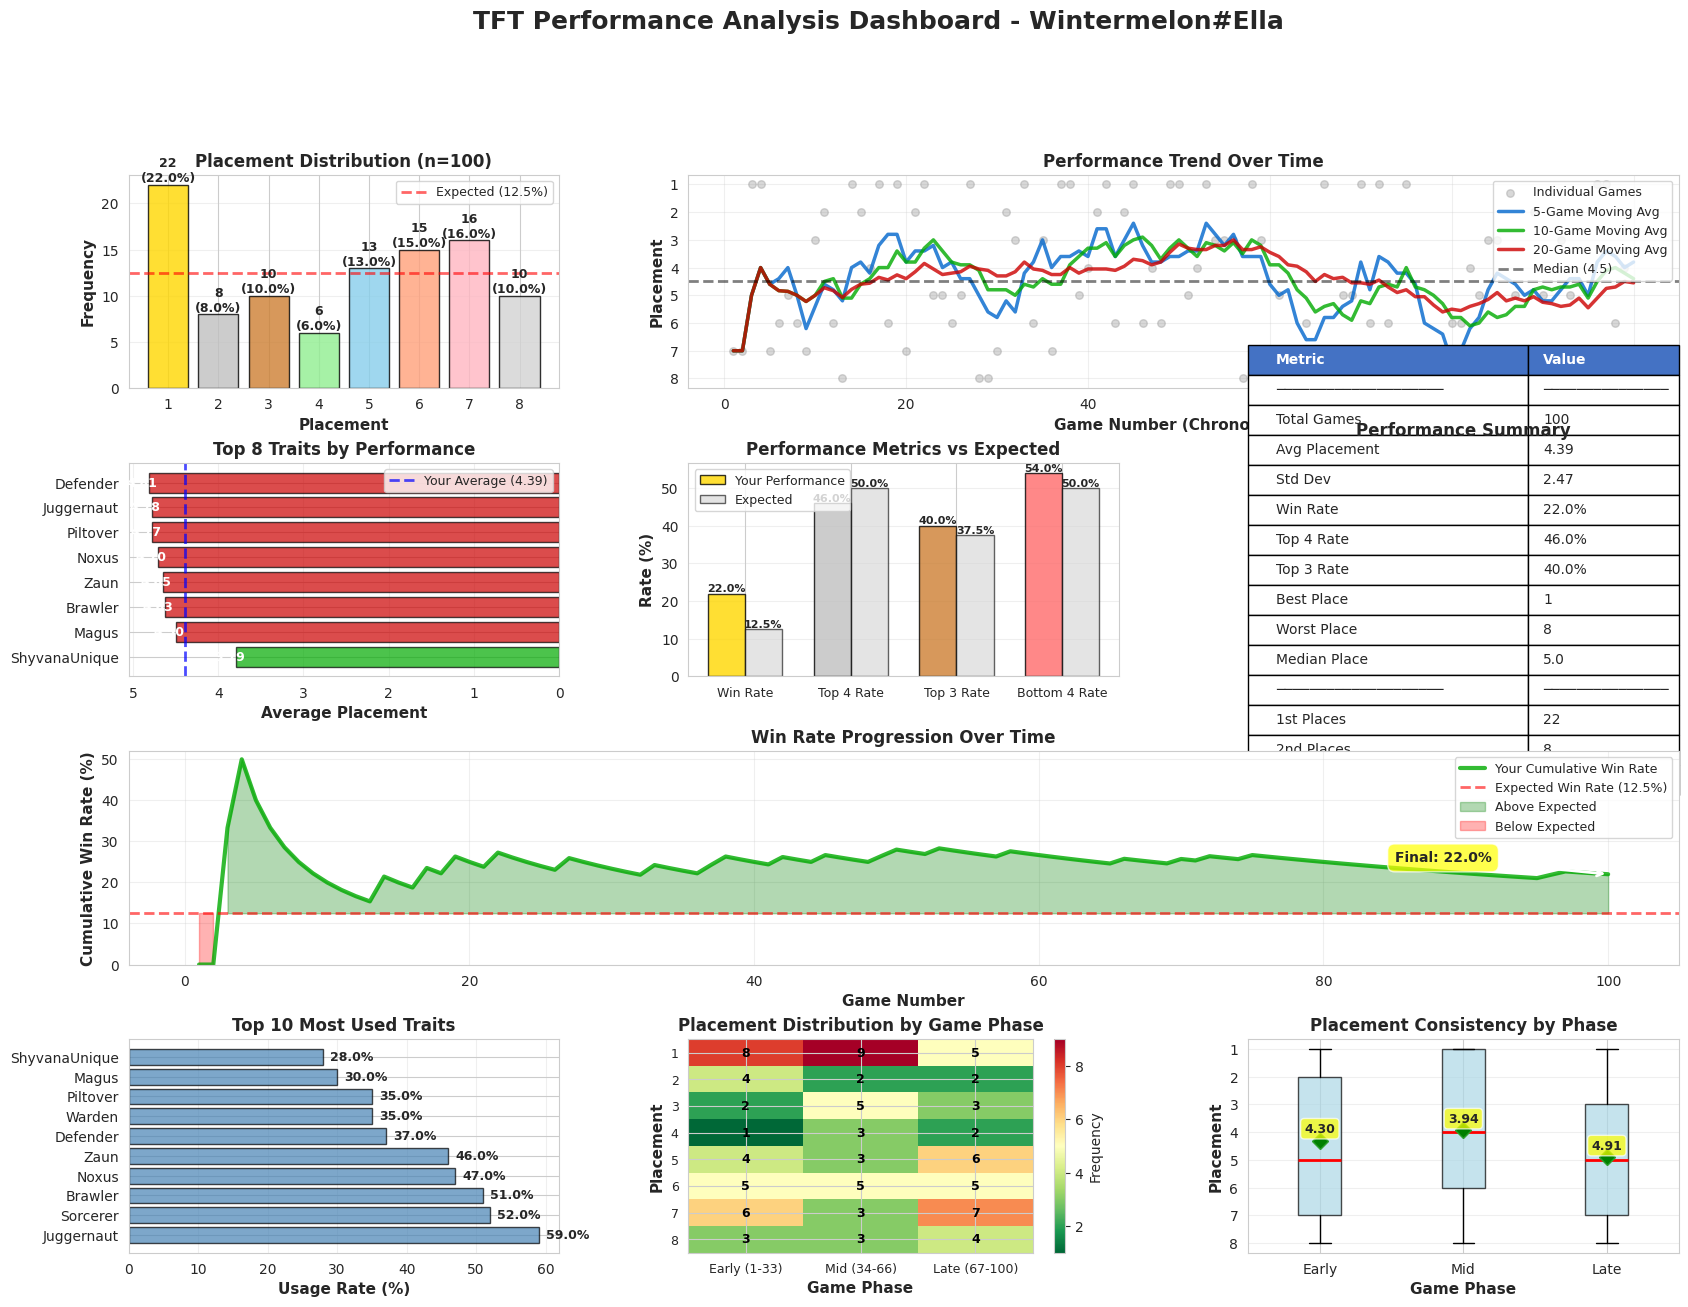


VISUALIZATION COMPLETE


In [47]:
# ===================================================================
# CELL 4: Performance Trends and Visualizations
# ===================================================================
# Extract player name from dataset
GAME_NAME = your_games['riotIdGameName'].iloc[0] if 'riotIdGameName' in your_games.columns else 'Player'
TAG_LINE = your_games['riotIdTagline'].iloc[0] if 'riotIdTagline' in your_games.columns else ''

print("\n" + "="*70)
print("PERFORMANCE TREND ANALYSIS & VISUALIZATIONS")
print("="*70)

# --- Start of added code for preprocessing ---
# Add game number for chronological analysis
your_games = your_games.reset_index(drop=True)
your_games['game_number'] = range(1, len(your_games) + 1)

# Calculate rolling averages
windows = [5, 10, 20]
for window in windows:
    your_games[f'rolling_avg_{window}'] = your_games['placement'].rolling(
        window=window, min_periods=1).mean()

# Performance phases
def identify_phase(placement):
    if placement <= 3:
        return 'Strong'
    elif placement <= 5:
        return 'Average'
    else:
        return 'Weak'

your_games['performance_phase'] = your_games['placement'].apply(identify_phase)
# --- End of added code for preprocessing ---

# Performance phases already calculated in earlier cell
phase_dist = your_games['performance_phase'].value_counts()
print(f"\nPerformance Phase Distribution:")
for phase in ['Strong', 'Average', 'Weak']:
    if phase in phase_dist.index:
        count = phase_dist[phase]
        print(f"  {phase:8s}: {count:3d} games ({count/len(your_games)*100:5.1f}%)")

# Create comprehensive dashboard
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# ===================================================================
# 1. Placement Distribution
# ===================================================================
ax1 = fig.add_subplot(gs[0, 0])
placement_counts = your_games['placement'].value_counts().sort_index()
colors = ['#FFD700', '#C0C0C0', '#CD7F32', '#90EE90',
          '#87CEEB', '#FFA07A', '#FFB6C1', '#D3D3D3']
bars = ax1.bar(placement_counts.index, placement_counts.values,
               color=colors[:len(placement_counts)], edgecolor='black', alpha=0.8)
ax1.axhline(len(your_games)/8, color='red', linestyle='--',
            linewidth=2, alpha=0.6, label='Expected (12.5%)')
ax1.set_xlabel('Placement', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title(f'Placement Distribution (n={len(your_games)})', fontsize=12, fontweight='bold')
ax1.set_xticks(range(1, 9))
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({height/len(your_games)*100:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# ===================================================================
# 2. Performance Trend Over Time
# ===================================================================
ax2 = fig.add_subplot(gs[0, 1:])
ax2.scatter(your_games['game_number'], your_games['placement'],
           alpha=0.3, s=30, color='gray', label='Individual Games')
colors_rolling = ['#0066CC', '#00AA00', '#CC0000']
for i, window in enumerate([5, 10, 20]):
    ax2.plot(your_games['game_number'],
            your_games[f'rolling_avg_{window}'],
            linewidth=2.5, color=colors_rolling[i],
            label=f'{window}-Game Moving Avg', alpha=0.8)
ax2.axhline(4.5, color='black', linestyle='--', linewidth=2, alpha=0.5, label='Median (4.5)')
ax2.set_xlabel('Game Number (Chronological)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Placement', fontsize=11, fontweight='bold')
ax2.set_title('Performance Trend Over Time', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=9)
ax2.invert_yaxis()
ax2.set_yticks(range(1, 9))
ax2.grid(True, alpha=0.3)

# ===================================================================
# 3. Trait Performance
# ===================================================================
ax3 = fig.add_subplot(gs[1, 0])
top_8_traits = trait_perf_df.head(8).copy()
colors_perf = ['#00AA00' if x < 4.39 else '#CC0000' for x in top_8_traits['Avg Placement']]
bars = ax3.barh(top_8_traits['Trait'], top_8_traits['Avg Placement'],
         color=colors_perf, edgecolor='black', alpha=0.7)
ax3.axvline(4.39, color='blue', linestyle='--', linewidth=2, alpha=0.7, label='Your Average (4.39)')
ax3.set_xlabel('Average Placement', fontsize=11, fontweight='bold')
ax3.set_title('Top 8 Traits by Performance', fontsize=12, fontweight='bold')
ax3.invert_xaxis()
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='x')

for i, (bar, val) in enumerate(zip(bars, top_8_traits['Avg Placement'])):
    ax3.text(val - 0.1, bar.get_y() + bar.get_height()/2,
            f'{val:.2f}', ha='right', va='center', fontsize=9, fontweight='bold', color='white')

# ===================================================================
# 4. Win & Top 4 Rates
# ===================================================================
ax4 = fig.add_subplot(gs[1, 1])
metrics = ['Win Rate', 'Top 4 Rate', 'Top 3 Rate', 'Bottom 4 Rate']
your_rates = [
    your_games['win'].mean() * 100,
    your_games['top_4'].mean() * 100,
    (your_games['placement'] <= 3).mean() * 100,
    (your_games['placement'] > 4).mean() * 100
]
expected_rates = [12.5, 50.0, 37.5, 50.0]
colors_metrics = ['#FFD700', '#C0C0C0', '#CD7F32', '#FF6B6B']

x = np.arange(len(metrics))
width = 0.35

bars1 = ax4.bar(x - width/2, your_rates, width, label='Your Performance',
               color=colors_metrics, edgecolor='black', alpha=0.8)
bars2 = ax4.bar(x + width/2, expected_rates, width, label='Expected',
               color='lightgray', edgecolor='black', alpha=0.6)

ax4.set_ylabel('Rate (%)', fontsize=11, fontweight='bold')
ax4.set_title('Performance Metrics vs Expected', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(metrics, fontsize=9)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8, fontweight='bold')

# ===================================================================
# 5. Summary Statistics Table
# ===================================================================
ax5 = fig.add_subplot(gs[1, 2])
ax5.axis('off')
summary_stats = [
    ['Metric', 'Value'],
    ['─'*20, '─'*15],
    ['Total Games', f'{len(your_games)}'],
    ['Avg Placement', f'{your_games["placement"].mean():.2f}'],
    ['Std Dev', f'{your_games["placement"].std():.2f}'],
    ['Win Rate', f'{your_games["win"].mean()*100:.1f}%'],
    ['Top 4 Rate', f'{your_games["top_4"].mean()*100:.1f}%'],
    ['Top 3 Rate', f'{(your_games["placement"]<=3).mean()*100:.1f}%'],
    ['Best Place', f'{your_games["placement"].min():.0f}'],
    ['Worst Place', f'{your_games["placement"].max():.0f}'],
    ['Median Place', f'{your_games["placement"].median():.1f}'],
    ['─'*20, '─'*15],
    ['1st Places', f'{(your_games["placement"]==1).sum()}'],
    ['2nd Places', f'{(your_games["placement"]==2).sum()}'],
    ['8th Places', f'{(your_games["placement"]==8).sum()}'],
]
table = ax5.table(cellText=summary_stats, loc='center',
                 cellLoc='left', colWidths=[0.65, 0.35])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.8)

# Style header
for i in range(2):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax5.set_title('Performance Summary', fontsize=12, fontweight='bold', pad=20)

# ===================================================================
# 6. Cumulative Win Rate
# ===================================================================
ax6 = fig.add_subplot(gs[2, :])
cumulative_wins = your_games['win'].cumsum()
cumulative_games = np.arange(1, len(your_games) + 1)
cumulative_winrate = cumulative_wins / cumulative_games * 100

ax6.plot(cumulative_games, cumulative_winrate,
         linewidth=3, color='#00AA00', alpha=0.8, label='Your Cumulative Win Rate')
ax6.axhline(12.5, color='red', linestyle='--', linewidth=2, alpha=0.6,
            label='Expected Win Rate (12.5%)')
ax6.fill_between(cumulative_games, cumulative_winrate, 12.5,
                 where=cumulative_winrate > 12.5,
                 alpha=0.3, color='green', label='Above Expected')
ax6.fill_between(cumulative_games, cumulative_winrate, 12.5,
                 where=cumulative_winrate <= 12.5,
                 alpha=0.3, color='red', label='Below Expected')
ax6.set_xlabel('Game Number', fontsize=11, fontweight='bold')
ax6.set_ylabel('Cumulative Win Rate (%)', fontsize=11, fontweight='bold')
ax6.set_title('Win Rate Progression Over Time', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9, loc='upper right')
ax6.grid(True, alpha=0.3)
ax6.set_ylim([0, max(30, cumulative_winrate.max() + 2)])

# Add final value annotation
final_wr = cumulative_winrate.iloc[-1]
ax6.annotate(f'Final: {final_wr:.1f}%',
            xy=(len(cumulative_games), final_wr),
            xytext=(len(cumulative_games)-15, final_wr+3),
            fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', lw=2))

# ===================================================================
# 7. Trait Usage Frequency
# ===================================================================
ax7 = fig.add_subplot(gs[3, 0])
top_10_trait_names = [t[0] for t in trait_counts.most_common(10)]
top_10_trait_counts = [t[1] for t in trait_counts.most_common(10)]
usage_rates = [c/len(your_games)*100 for c in top_10_trait_counts]

bars = ax7.barh(top_10_trait_names, usage_rates, color='steelblue', edgecolor='black', alpha=0.7)
ax7.set_xlabel('Usage Rate (%)', fontsize=11, fontweight='bold')
ax7.set_title('Top 10 Most Used Traits', fontsize=12, fontweight='bold')
ax7.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, usage_rates):
    ax7.text(val + 1, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}%', ha='left', va='center', fontsize=9, fontweight='bold')

# ===================================================================
# 8. Placement Heatmap by Game Phase
# ===================================================================
ax8 = fig.add_subplot(gs[3, 1])
# Divide games into early, mid, late phases
your_games['phase'] = pd.cut(your_games['game_number'],
                             bins=[0, 33, 66, 100],
                             labels=['Early (1-33)', 'Mid (34-66)', 'Late (67-100)'])
phase_placement = your_games.groupby(['phase', 'placement']).size().unstack(fill_value=0)

# Create heatmap
im = ax8.imshow(phase_placement.T, cmap='RdYlGn_r', aspect='auto', interpolation='nearest')
ax8.set_xticks(range(len(phase_placement.index)))
ax8.set_xticklabels(phase_placement.index, fontsize=9)
ax8.set_yticks(range(len(phase_placement.columns)))
ax8.set_yticklabels(phase_placement.columns, fontsize=9)
ax8.set_xlabel('Game Phase', fontsize=11, fontweight='bold')
ax8.set_ylabel('Placement', fontsize=11, fontweight='bold')
ax8.set_title('Placement Distribution by Game Phase', fontsize=12, fontweight='bold')

# Add text annotations
for i in range(len(phase_placement.index)):
    for j in range(len(phase_placement.columns)):
        text = ax8.text(i, j, phase_placement.iloc[i, j],
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

plt.colorbar(im, ax=ax8, label='Frequency')

# ===================================================================
# 9. Performance Consistency
# ===================================================================
ax9 = fig.add_subplot(gs[3, 2])
# Box plot of placements over time
phases_data = [your_games[your_games['phase'] == phase]['placement'].values
               for phase in ['Early (1-33)', 'Mid (34-66)', 'Late (67-100)']]

bp = ax9.boxplot(phases_data, labels=['Early', 'Mid', 'Late'],
                 patch_artist=True, showmeans=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 meanprops=dict(marker='D', markerfacecolor='green', markersize=8))

ax9.set_ylabel('Placement', fontsize=11, fontweight='bold')
ax9.set_xlabel('Game Phase', fontsize=11, fontweight='bold')
ax9.set_title('Placement Consistency by Phase', fontsize=12, fontweight='bold')
ax9.invert_yaxis()
ax9.grid(True, alpha=0.3, axis='y')
ax9.set_yticks(range(1, 9))

# Add mean values as text
for i, phase_data in enumerate(phases_data):
    mean_val = phase_data.mean()
    ax9.text(i+1, mean_val - 0.3, f'{mean_val:.2f}',
            ha='center', fontsize=9, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# ===================================================================
# Main Title
# ===================================================================
plt.suptitle(f'TFT Performance Analysis Dashboard - {GAME_NAME}#{TAG_LINE}',
             fontsize=18, fontweight='bold', y=0.998)

# Save figure
plt.savefig('tft_performance_dashboard.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: tft_performance_dashboard.png (high resolution)")

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("VISUALIZATION COMPLETE")
print("="*70)

In [48]:
# ===================================================================
# CELL 5: Export Results and Final Summary
# ===================================================================

print("\n" + "="*70)
print("EXPORTING ANALYSIS RESULTS FOR DOCUMENTATION")
print("="*70)

# ===================================================================
# Table 1: Overall Performance Summary
# ===================================================================
overall_summary = pd.DataFrame({
    'Metric': [
        'Total Games',
        'Average Placement',
        'Standard Deviation',
        'Median Placement',
        'Win Rate (%)',
        'Top 4 Rate (%)',
        'Top 3 Rate (%)',
        'Bottom 4 Rate (%)',
        'Best Placement',
        'Worst Placement',
        '1st Place Finishes',
        '2nd Place Finishes',
        '3rd Place Finishes',
        '4th Place Finishes',
        '5th Place Finishes',
        '6th Place Finishes',
        '7th Place Finishes',
        '8th Place Finishes'
    ],
    'Value': [
        len(your_games),
        f'{your_games["placement"].mean():.3f}',
        f'{your_games["placement"].std():.3f}',
        f'{your_games["placement"].median():.1f}',
        f'{your_games["win"].mean()*100:.2f}',
        f'{your_games["top_4"].mean()*100:.2f}',
        f'{(your_games["placement"] <= 3).mean()*100:.2f}',
        f'{(your_games["placement"] > 4).mean()*100:.2f}',
        int(your_games["placement"].min()),
        int(your_games["placement"].max()),
        int((your_games["placement"] == 1).sum()),
        int((your_games["placement"] == 2).sum()),
        int((your_games["placement"] == 3).sum()),
        int((your_games["placement"] == 4).sum()),
        int((your_games["placement"] == 5).sum()),
        int((your_games["placement"] == 6).sum()),
        int((your_games["placement"] == 7).sum()),
        int((your_games["placement"] == 8).sum())
    ]
})
overall_summary.to_csv('analysis_overall_summary.csv', index=False)
print("\n✅ Exported: analysis_overall_summary.csv")

# ===================================================================
# Table 2: Trait Performance
# ===================================================================
trait_perf_df.to_csv('analysis_trait_performance.csv', index=False)
print("✅ Exported: analysis_trait_performance.csv")
print(f"   Contains: {len(trait_perf_df)} traits analyzed")

# ===================================================================
# Table 3: Augment Recommendations (Global Data)
# ===================================================================
if not aug_perf_df.empty:
    # Select top augments for recommendations
    recommended_augments = aug_perf_df[
        (aug_perf_df['Win Rate'] > 15) |
        (aug_perf_df['Average Placement'] < 4.2)
    ].sort_values('Win Rate', ascending=False)

    recommended_augments.to_csv('analysis_augment_recommendations.csv', index=False)
    print("✅ Exported: analysis_augment_recommendations.csv")
    print(f"   Contains: {len(recommended_augments)} recommended augments")

# ===================================================================
# Table 4: Performance by Phase
# ===================================================================
phase_summary = your_games.groupby('performance_phase').agg({
    'placement': ['count', 'mean', 'median', 'std'],
    'win': 'mean',
    'top_4': 'mean'
}).reset_index()

phase_summary.columns = ['Phase', 'Games', 'Avg Placement', 'Median Placement',
                         'Std Dev', 'Win Rate', 'Top 4 Rate']
phase_summary['Win Rate'] = phase_summary['Win Rate'] * 100
phase_summary['Top 4 Rate'] = phase_summary['Top 4 Rate'] * 100

phase_summary.to_csv('analysis_performance_by_phase.csv', index=False)
print("✅ Exported: analysis_performance_by_phase.csv")

# ===================================================================
# Table 5: Time-based Analysis (Early/Mid/Late games)
# ===================================================================
time_phase_summary = your_games.groupby('phase').agg({
    'placement': ['count', 'mean', 'median'],
    'win': 'mean',
    'top_4': 'mean'
}).reset_index()

time_phase_summary.columns = ['Game Phase', 'Games', 'Avg Placement',
                              'Median Placement', 'Win Rate', 'Top 4 Rate']
time_phase_summary['Win Rate'] = time_phase_summary['Win Rate'] * 100
time_phase_summary['Top 4 Rate'] = time_phase_summary['Top 4 Rate'] * 100

time_phase_summary.to_csv('analysis_temporal_trends.csv', index=False)
print("✅ Exported: analysis_temporal_trends.csv")

# ===================================================================
# Table 6: Most Used Traits with Performance
# ===================================================================
top_traits_detailed = trait_perf_df.head(15).copy()
top_traits_detailed.to_csv('analysis_top_traits_detailed.csv', index=False)
print("✅ Exported: analysis_top_traits_detailed.csv")
print(f"   Contains: Top 15 traits with detailed stats")

# ===================================================================
# Generate Statistical Report
# ===================================================================
print("\n" + "="*70)
print("GENERATING STATISTICAL ANALYSIS REPORT")
print("="*70)

# Statistical tests
from scipy.stats import normaltest, ttest_1samp

# Test for normality
stat, p_value_normal = normaltest(your_games['placement'])
print(f"\nNormality Test (D'Agostino-Pearson):")
print(f"  Statistic: {stat:.4f}")
print(f"  P-value: {p_value_normal:.4f}")
print(f"  Result: {'Normally distributed' if p_value_normal > 0.05 else 'Not normally distributed'}")

# T-test: Is your average placement significantly different from 4.5?
stat, p_value_ttest = ttest_1samp(your_games['placement'], 4.5)
print(f"\nOne-Sample T-Test (vs expected mean of 4.5):")
print(f"  Your mean: {your_games['placement'].mean():.3f}")
print(f"  Expected mean: 4.5")
print(f"  T-statistic: {stat:.4f}")
print(f"  P-value: {p_value_ttest:.4f}")
print(f"  Result: {'Significantly different' if p_value_ttest < 0.05 else 'Not significantly different'} from expected")

# Win rate test (binomial proportion)
from scipy.stats import binomtest
win_count = your_games['win'].sum()
total_games = len(your_games)
result = binomtest(win_count, total_games, 0.125, alternative='two-sided')
print(f"\nBinomial Test for Win Rate:")
print(f"  Your wins: {win_count}/{total_games} ({win_count/total_games*100:.1f}%)")
print(f"  Expected: {0.125*100:.1f}%")
print(f"  P-value: {result.pvalue:.4f}")
print(f"  Result: {'Significantly different' if result.pvalue < 0.05 else 'Not significantly different'} from expected")

# Save statistical report
stats_report = {
    'Test': ['Normality Test', 'T-Test (Placement)', 'Binomial Test (Win Rate)'],
    'Statistic': [f'{stat:.4f}', f'{stat:.4f}', 'N/A'],
    'P-value': [f'{p_value_normal:.4f}', f'{p_value_ttest:.4f}', f'{result.pvalue:.4f}'],
    'Significant': [
        'No' if p_value_normal > 0.05 else 'Yes',
        'No' if p_value_ttest > 0.05 else 'Yes',
        'No' if result.pvalue > 0.05 else 'Yes'
    ]
}
stats_df = pd.DataFrame(stats_report)
stats_df.to_csv('analysis_statistical_tests.csv', index=False)
print("\n✅ Exported: analysis_statistical_tests.csv")

# ===================================================================
# Create Final Summary Report
# ===================================================================
print("\n" + "="*70)
print("FINAL ANALYSIS COMPLETE!")
print("="*70)

# Calculate key insights
avg_placement = your_games['placement'].mean()
win_rate = your_games['win'].mean() * 100
top4_rate = your_games['top_4'].mean() * 100
best_trait = trait_perf_df.iloc[0]['Trait'] if len(trait_perf_df) > 0 else 'N/A'
best_trait_placement = trait_perf_df.iloc[0]['Avg Placement'] if len(trait_perf_df) > 0 else 0

print(f"""
📊 PERFORMANCE SUMMARY - {GAME_NAME}#{TAG_LINE}
{'='*70}

🎮 Overall Statistics:
   • Total Games Analyzed: {len(your_games)}
   • Average Placement: {avg_placement:.2f} (Rank: {"Above Average" if avg_placement < 4.5 else "Below Average"})
   • Win Rate: {win_rate:.1f}% (Expected: 12.5%) - {(win_rate/12.5-1)*100:+.1f}% difference
   • Top 4 Rate: {top4_rate:.1f}% (Expected: 50.0%) - {top4_rate-50:+.1f}% difference

🏆 Key Achievements:
   • 1st Place Finishes: {(your_games['placement']==1).sum()} ({(your_games['placement']==1).mean()*100:.1f}%)
   • Top 3 Finishes: {(your_games['placement']<=3).sum()} ({(your_games['placement']<=3).mean()*100:.1f}%)
   • Consistency: {your_games['placement'].std():.2f} std dev

🎯 Best Performing Strategy:
   • Top Trait: {best_trait}
   • Average Placement with {best_trait}: {best_trait_placement:.2f}

📈 Performance Phases:
   • Strong Games (1st-3rd): {(your_games['performance_phase']=='Strong').sum()} ({(your_games['performance_phase']=='Strong').mean()*100:.1f}%)
   • Average Games (4th-5th): {(your_games['performance_phase']=='Average').sum()} ({(your_games['performance_phase']=='Average').mean()*100:.1f}%)
   • Weak Games (6th-8th): {(your_games['performance_phase']=='Weak').sum()} ({(your_games['performance_phase']=='Weak').mean()*100:.1f}%)

📉 Areas for Improvement:
   • {'Bottom 4 rate is high - focus on early game economy' if (your_games['placement']>4).mean() > 0.55 else 'Good consistency - maintain current strategy'}
   • {'Win rate below expected - work on closing out games' if win_rate < 12.5 else 'Win rate above expected - excellent performance!'}

🔬 Statistical Significance:
   • Placement vs Expected (4.5): {'Significantly different' if p_value_ttest < 0.05 else 'Not significantly different'} (p={p_value_ttest:.4f})
   • Win Rate vs Expected (12.5%): {'Significantly different' if result.pvalue < 0.05 else 'Not significantly different'} (p={result.pvalue:.4f})

{'='*70}

📁 Files Generated:
   1. tft_performance_dashboard.png - Visual analysis dashboard
   2. analysis_overall_summary.csv - Complete performance metrics
   3. analysis_trait_performance.csv - Trait-by-trait analysis
   4. analysis_augment_recommendations.csv - Recommended augments
   5. analysis_performance_by_phase.csv - Phase-based breakdown
   6. analysis_temporal_trends.csv - Performance over time
   7. analysis_top_traits_detailed.csv - Detailed trait statistics
   8. analysis_statistical_tests.csv - Statistical test results

✅ All analysis complete and ready for documentation!
{'='*70}
""")

# Create a summary text file
with open('ANALYSIS_SUMMARY.txt', 'w') as f:
    f.write(f"TFT PERFORMANCE ANALYSIS SUMMARY\n")
    f.write(f"Player: {GAME_NAME}#{TAG_LINE}\n")
    f.write(f"Analysis Date: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"="*70 + "\n\n")
    f.write(f"Total Games: {len(your_games)}\n")
    f.write(f"Average Placement: {avg_placement:.3f}\n")
    f.write(f"Win Rate: {win_rate:.2f}%\n")
    f.write(f"Top 4 Rate: {top4_rate:.2f}%\n")
    f.write(f"\nBest Performing Trait: {best_trait} (Avg: {best_trait_placement:.2f})\n")
    f.write(f"\nPerformance Distribution:\n")
    f.write(f"  Strong Games: {(your_games['performance_phase']=='Strong').sum()}\n")
    f.write(f"  Average Games: {(your_games['performance_phase']=='Average').sum()}\n")
    f.write(f"  Weak Games: {(your_games['performance_phase']=='Weak').sum()}\n")

print("\n✅ Exported: ANALYSIS_SUMMARY.txt")
print("\n" + "="*70)


EXPORTING ANALYSIS RESULTS FOR DOCUMENTATION

✅ Exported: analysis_overall_summary.csv
✅ Exported: analysis_trait_performance.csv
   Contains: 10 traits analyzed
✅ Exported: analysis_augment_recommendations.csv
   Contains: 30 recommended augments
✅ Exported: analysis_performance_by_phase.csv
✅ Exported: analysis_temporal_trends.csv
✅ Exported: analysis_top_traits_detailed.csv
   Contains: Top 15 traits with detailed stats

GENERATING STATISTICAL ANALYSIS REPORT

Normality Test (D'Agostino-Pearson):
  Statistic: 106.9932
  P-value: 0.0000
  Result: Not normally distributed

One-Sample T-Test (vs expected mean of 4.5):
  Your mean: 4.390
  Expected mean: 4.5
  T-statistic: -0.4462
  P-value: 0.6565
  Result: Not significantly different from expected

Binomial Test for Win Rate:
  Your wins: 22/100 (22.0%)
  Expected: 12.5%
  P-value: 0.0091
  Result: Significantly different from expected

✅ Exported: analysis_statistical_tests.csv

FINAL ANALYSIS COMPLETE!

📊 PERFORMANCE SUMMARY - Wint


STATISTICAL SIGNIFICANCE ANALYSIS VISUALIZATIONS

✅ Saved: tft_statistical_analysis.png


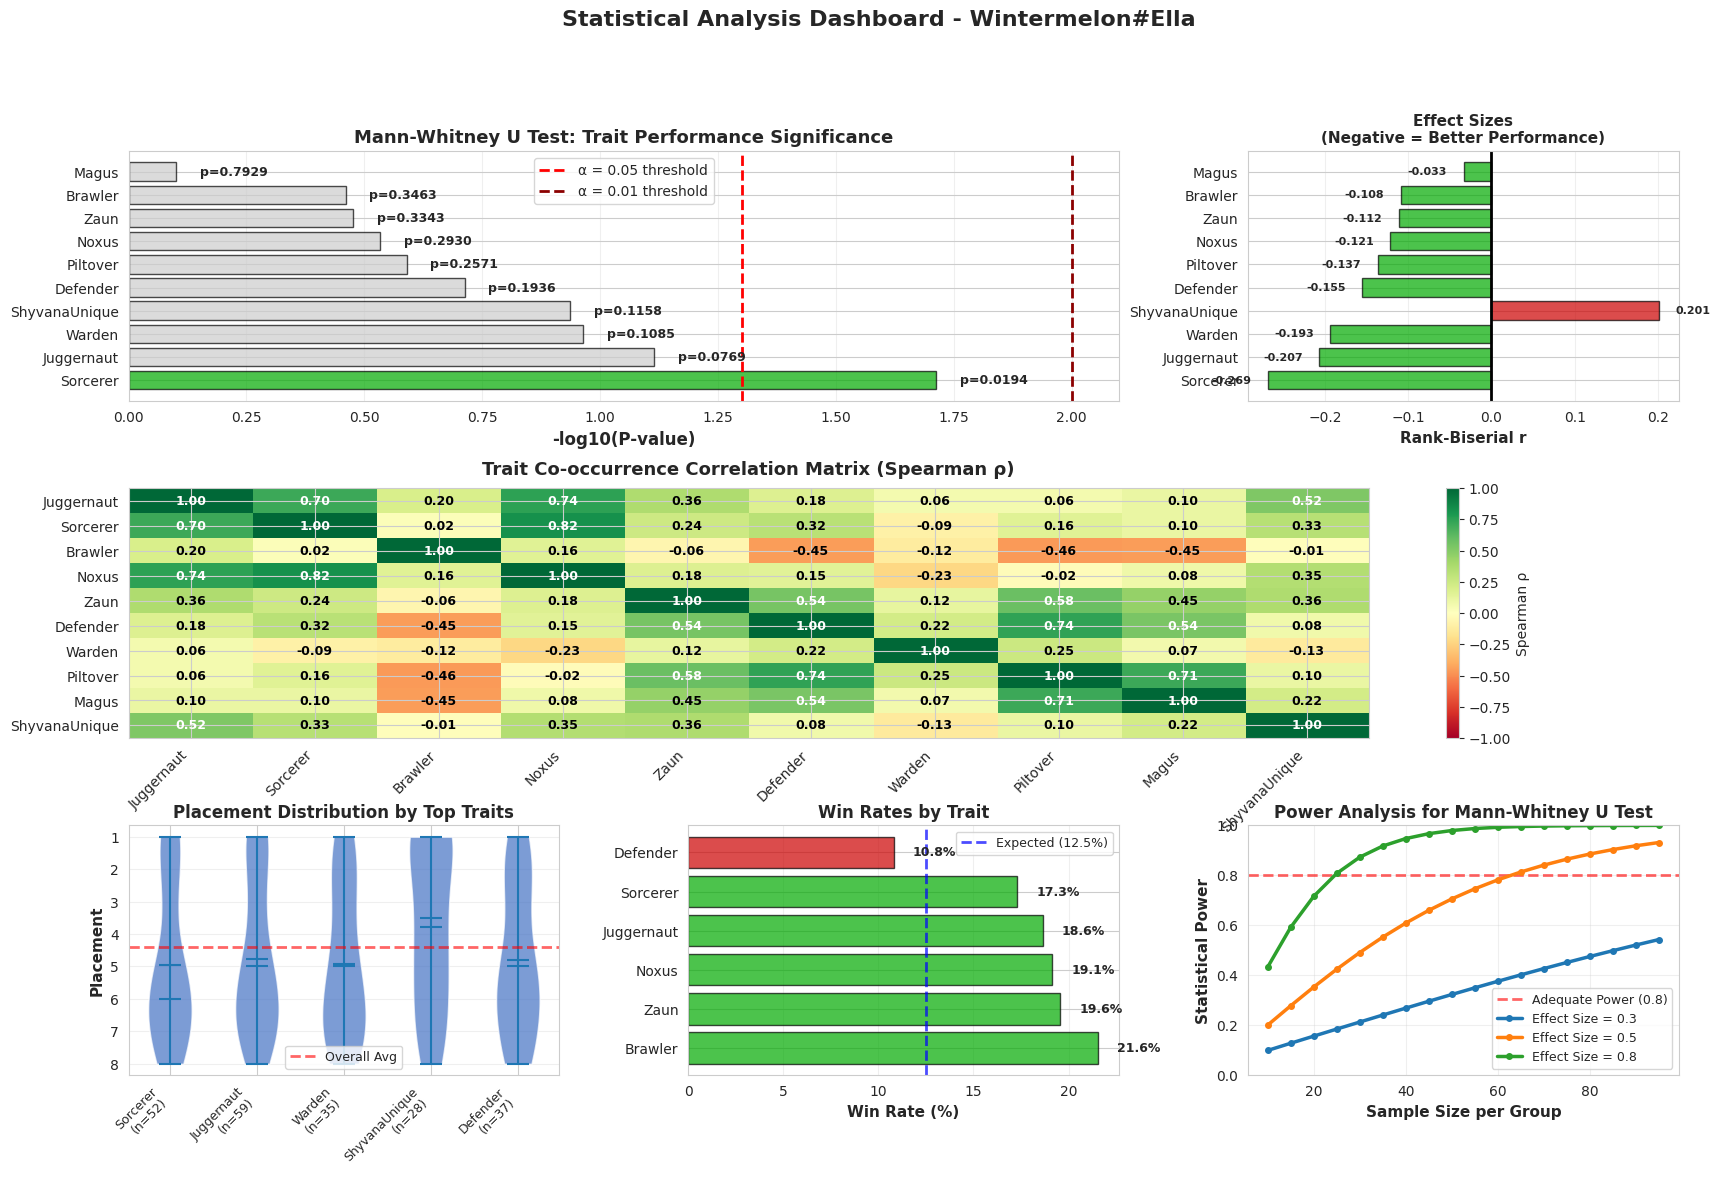

✅ Exported: analysis_mann_whitney_results.csv



In [49]:
# ===================================================================
# CELL 6: Statistical Significance Visualizations
# ===================================================================

print("\n" + "="*70)
print("STATISTICAL SIGNIFICANCE ANALYSIS VISUALIZATIONS")
print("="*70)

# Create figure for statistical analysis visualizations
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# ===================================================================
# 1. Mann-Whitney U Test Results for Traits
# ===================================================================
ax1 = fig.add_subplot(gs[0, :2])

# Perform Mann-Whitney U tests for top traits
trait_stats = []
for trait in top_10_traits:
    games_with = your_games[your_games['trait_list'].apply(lambda x: trait in x)]
    games_without = your_games[~your_games['trait_list'].apply(lambda x: trait in x)]

    if len(games_with) >= 5 and len(games_without) >= 5:
        statistic, p_value = mannwhitneyu(games_with['placement'],
                                          games_without['placement'],
                                          alternative='two-sided')

        # Calculate rank-biserial correlation (effect size)
        n1, n2 = len(games_with), len(games_without)
        rank_biserial = 1 - (2*statistic) / (n1 * n2)

        trait_stats.append({
            'Trait': trait,
            'P-value': p_value,
            'Effect Size': rank_biserial,
            'Significant': 'Yes' if p_value < 0.05 else 'No',
            'Avg Placement': games_with['placement'].mean()
        })

trait_stats_df = pd.DataFrame(trait_stats).sort_values('P-value')

# Create visualization
colors = ['#00AA00' if p < 0.05 else '#CCCCCC' for p in trait_stats_df['P-value']]
bars = ax1.barh(trait_stats_df['Trait'], -np.log10(trait_stats_df['P-value']),
                color=colors, edgecolor='black', alpha=0.7)

ax1.axvline(-np.log10(0.05), color='red', linestyle='--', linewidth=2,
            label='α = 0.05 threshold')
ax1.axvline(-np.log10(0.01), color='darkred', linestyle='--', linewidth=2,
            label='α = 0.01 threshold')

ax1.set_xlabel('-log10(P-value)', fontsize=12, fontweight='bold')
ax1.set_title('Mann-Whitney U Test: Trait Performance Significance',
              fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='x')

# Add p-value annotations
for i, (bar, pval) in enumerate(zip(bars, trait_stats_df['P-value'])):
    ax1.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2,
            f'p={pval:.4f}', ha='left', va='center', fontsize=9, fontweight='bold')

# ===================================================================
# 2. Effect Size (Rank-Biserial Correlation)
# ===================================================================
ax2 = fig.add_subplot(gs[0, 2])

colors_effect = ['#00AA00' if x < 0 else '#CC0000' for x in trait_stats_df['Effect Size']]
bars = ax2.barh(trait_stats_df['Trait'], trait_stats_df['Effect Size'],
                color=colors_effect, edgecolor='black', alpha=0.7)

ax2.axvline(0, color='black', linestyle='-', linewidth=2)
ax2.set_xlabel('Rank-Biserial r', fontsize=11, fontweight='bold')
ax2.set_title('Effect Sizes\n(Negative = Better Performance)',
              fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, trait_stats_df['Effect Size']):
    x_pos = val + (0.02 if val > 0 else -0.02)
    ha = 'left' if val > 0 else 'right'
    ax2.text(x_pos, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', ha=ha, va='center', fontsize=8, fontweight='bold')

# ===================================================================
# 3. Spearman Correlation Heatmap (Trait Co-occurrence)
# ===================================================================
ax3 = fig.add_subplot(gs[1, :])

# Create trait co-occurrence matrix
trait_matrix = pd.DataFrame(0, index=top_10_traits, columns=top_10_traits)

for _, row in your_games.iterrows():
    traits = row['trait_list']
    for i, trait1 in enumerate(top_10_traits):
        for trait2 in top_10_traits[i:]:
            if trait1 in traits and trait2 in traits:
                trait_matrix.loc[trait1, trait2] += 1
                if trait1 != trait2:
                    trait_matrix.loc[trait2, trait1] += 1

# Calculate correlation with placement
correlation_matrix = pd.DataFrame(0.0, index=top_10_traits, columns=top_10_traits)

for i, trait1 in enumerate(top_10_traits):
    for j, trait2 in enumerate(top_10_traits):
        # Create binary indicators
        has_trait1 = your_games['trait_list'].apply(lambda x: trait1 in x).astype(int)
        has_trait2 = your_games['trait_list'].apply(lambda x: trait2 in x).astype(int)

        if has_trait1.sum() > 0 and has_trait2.sum() > 0:
            corr, _ = spearmanr(has_trait1, has_trait2)
            correlation_matrix.iloc[i, j] = corr

# Plot heatmap
im = ax3.imshow(correlation_matrix.values, cmap='RdYlGn', aspect='auto',
                vmin=-1, vmax=1)
ax3.set_xticks(range(len(top_10_traits)))
ax3.set_yticks(range(len(top_10_traits)))
ax3.set_xticklabels(top_10_traits, rotation=45, ha='right', fontsize=10)
ax3.set_yticklabels(top_10_traits, fontsize=10)
ax3.set_title('Trait Co-occurrence Correlation Matrix (Spearman ρ)',
              fontsize=13, fontweight='bold', pad=10)

# Add correlation values as text
for i in range(len(top_10_traits)):
    for j in range(len(top_10_traits)):
        value = correlation_matrix.iloc[i, j]
        color = 'white' if abs(value) > 0.5 else 'black'
        ax3.text(j, i, f'{value:.2f}', ha="center", va="center",
                color=color, fontsize=9, fontweight='bold')

plt.colorbar(im, ax=ax3, label='Spearman ρ')

# ===================================================================
# 4. Placement Distribution by Trait (Violin Plot)
# ===================================================================
ax4 = fig.add_subplot(gs[2, 0])

# Select top 5 significant traits for violin plot
sig_traits = trait_stats_df[trait_stats_df['Significant'] == 'Yes']['Trait'].head(5).tolist()
if len(sig_traits) < 5:
    sig_traits = trait_stats_df['Trait'].head(5).tolist()

violin_data = []
labels = []
for trait in sig_traits:
    games_with = your_games[your_games['trait_list'].apply(lambda x: trait in x)]
    violin_data.append(games_with['placement'].values)
    labels.append(f"{trait}\n(n={len(games_with)})")

parts = ax4.violinplot(violin_data, positions=range(len(sig_traits)),
                       showmeans=True, showmedians=True)

# Color the violins
for pc in parts['bodies']:
    pc.set_facecolor('#4472C4')
    pc.set_alpha(0.7)

ax4.set_xticks(range(len(sig_traits)))
ax4.set_xticklabels(labels, rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Placement', fontsize=11, fontweight='bold')
ax4.set_title('Placement Distribution by Top Traits', fontsize=12, fontweight='bold')
ax4.axhline(4.39, color='red', linestyle='--', linewidth=2, alpha=0.6,
            label='Overall Avg')
ax4.invert_yaxis()
ax4.grid(True, alpha=0.3, axis='y')
ax4.legend(fontsize=9)

# ===================================================================
# 5. Win Rate Comparison (Traits vs Expected)
# ===================================================================
ax5 = fig.add_subplot(gs[2, 1])

trait_win_rates = []
for trait in top_10_traits[:6]:
    games_with = your_games[your_games['trait_list'].apply(lambda x: trait in x)]
    win_rate = games_with['win'].mean() * 100
    trait_win_rates.append({'Trait': trait, 'Win Rate': win_rate})

trait_wr_df = pd.DataFrame(trait_win_rates).sort_values('Win Rate', ascending=False)

colors_wr = ['#00AA00' if wr > 12.5 else '#CC0000' for wr in trait_wr_df['Win Rate']]
bars = ax5.barh(trait_wr_df['Trait'], trait_wr_df['Win Rate'],
                color=colors_wr, edgecolor='black', alpha=0.7)

ax5.axvline(12.5, color='blue', linestyle='--', linewidth=2, alpha=0.7,
            label='Expected (12.5%)')
ax5.set_xlabel('Win Rate (%)', fontsize=11, fontweight='bold')
ax5.set_title('Win Rates by Trait', fontsize=12, fontweight='bold')
ax5.legend(fontsize=9)
ax5.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, trait_wr_df['Win Rate']):
    ax5.text(val + 1, bar.get_y() + bar.get_height()/2,
            f'{val:.1f}%', ha='left', va='center', fontsize=9, fontweight='bold')

# ===================================================================
# 6. Statistical Power Analysis
# ===================================================================
ax6 = fig.add_subplot(gs[2, 2])

# Create sample size vs power plot
sample_sizes = np.arange(10, 100, 5)
effect_sizes = [0.3, 0.5, 0.8]
alpha = 0.05

ax6.axhline(0.8, color='red', linestyle='--', linewidth=2, alpha=0.6,
            label='Adequate Power (0.8)')

for es in effect_sizes:
    # Approximate power calculation for Mann-Whitney U test
    # Power ≈ 1 - β where β is Type II error probability
    powers = []
    for n in sample_sizes:
        # Simplified power approximation
        z_alpha = stats.norm.ppf(1 - alpha/2)
        z_beta = es * np.sqrt(n/2) - z_alpha
        power = stats.norm.cdf(z_beta)
        powers.append(power)

    ax6.plot(sample_sizes, powers, linewidth=2.5,
            label=f'Effect Size = {es}', marker='o', markersize=4)

ax6.set_xlabel('Sample Size per Group', fontsize=11, fontweight='bold')
ax6.set_ylabel('Statistical Power', fontsize=11, fontweight='bold')
ax6.set_title('Power Analysis for Mann-Whitney U Test', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3)
ax6.set_ylim([0, 1])

# Main title
plt.suptitle(f'Statistical Analysis Dashboard - {GAME_NAME}#{TAG_LINE}',
             fontsize=16, fontweight='bold', y=0.998)

plt.savefig('tft_statistical_analysis.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: tft_statistical_analysis.png")
plt.tight_layout()
plt.show()

# Export statistical test results
trait_stats_df.to_csv('analysis_mann_whitney_results.csv', index=False)
print("✅ Exported: analysis_mann_whitney_results.csv")

print("\n" + "="*70)


AUGMENT PERFORMANCE WITH WILSON CONFIDENCE INTERVALS

✅ Saved: tft_augment_confidence_intervals.png


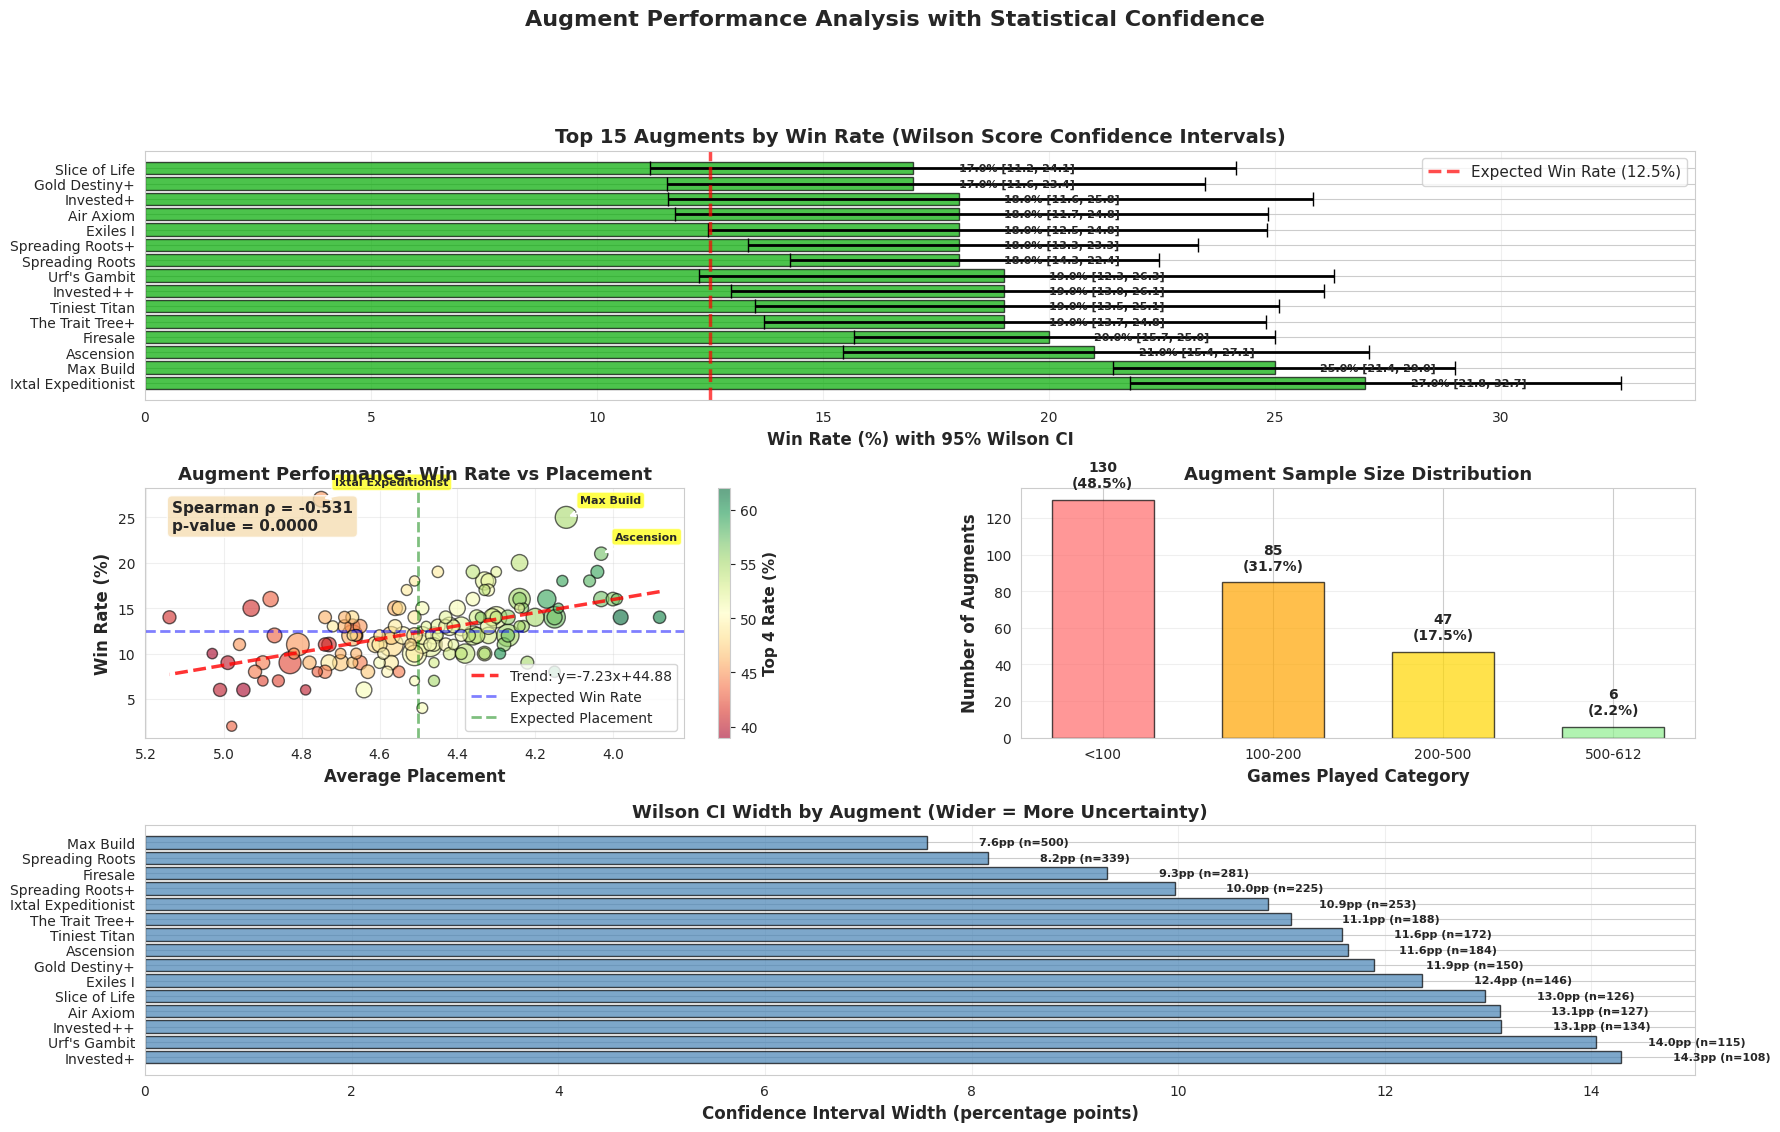

✅ Exported: analysis_augments_with_confidence.csv



In [50]:
# ===================================================================
# CELL 7: Augment Performance Visualizations with Confidence Intervals
# ===================================================================

print("\n" + "="*70)
print("AUGMENT PERFORMANCE WITH WILSON CONFIDENCE INTERVALS")
print("="*70)

# Wilson score confidence interval function
def wilson_confidence_interval(successes, trials, confidence=0.95):
    """Calculate Wilson score confidence interval"""
    if trials == 0:
        return 0, 0, 0

    p_hat = successes / trials
    z = stats.norm.ppf(1 - (1 - confidence) / 2)

    denominator = 1 + z**2 / trials
    center = (p_hat + z**2 / (2 * trials)) / denominator
    margin = z * np.sqrt((p_hat * (1 - p_hat) / trials + z**2 / (4 * trials**2))) / denominator

    lower = center - margin
    upper = center + margin

    return lower * 100, center * 100, upper * 100

# Calculate Wilson intervals for top augments
top_augments = reliable_augments.nlargest(15, 'Win Rate').copy()
top_augments['CI_Lower'] = 0.0
top_augments['CI_Upper'] = 0.0

for idx, row in top_augments.iterrows():
    wins = int(row['Win Rate'] * row['Games Played'] / 100)
    trials = int(row['Games Played'])
    lower, center, upper = wilson_confidence_interval(wins, trials)
    top_augments.at[idx, 'CI_Lower'] = lower
    top_augments.at[idx, 'CI_Upper'] = upper

# Create augment visualization figure
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 2, hspace=0.35, wspace=0.3)

# ===================================================================
# 1. Win Rate with Wilson Confidence Intervals
# ===================================================================
ax1 = fig.add_subplot(gs[0, :])

y_pos = np.arange(len(top_augments))
win_rates = top_augments['Win Rate'].values
ci_lower = top_augments['CI_Lower'].values
ci_upper = top_augments['CI_Upper'].values
errors = np.array([win_rates - ci_lower, ci_upper - win_rates])

colors_aug = ['#00AA00' if wr > 15 else '#4472C4' for wr in win_rates]
bars = ax1.barh(y_pos, win_rates, xerr=errors, color=colors_aug,
                edgecolor='black', alpha=0.7, capsize=5, error_kw={'linewidth': 2})

ax1.axvline(12.5, color='red', linestyle='--', linewidth=2.5, alpha=0.7,
            label='Expected Win Rate (12.5%)')
ax1.set_yticks(y_pos)
ax1.set_yticklabels(top_augments['Augment Name'], fontsize=10)
ax1.set_xlabel('Win Rate (%) with 95% Wilson CI', fontsize=12, fontweight='bold')
ax1.set_title('Top 15 Augments by Win Rate (Wilson Score Confidence Intervals)',
              fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='x')

# Add value annotations
for i, (bar, wr, lower, upper) in enumerate(zip(bars, win_rates, ci_lower, ci_upper)):
    ax1.text(wr + 1, i, f'{wr:.1f}% [{lower:.1f}, {upper:.1f}]',
            ha='left', va='center', fontsize=8, fontweight='bold')

# ===================================================================
# 2. Average Placement vs Win Rate Scatter
# ===================================================================
ax2 = fig.add_subplot(gs[1, 0])

scatter = ax2.scatter(reliable_augments['Average Placement'],
                     reliable_augments['Win Rate'],
                     s=reliable_augments['Games Played'] / 2,
                     c=reliable_augments['Top 4'] * 100,
                     cmap='RdYlGn', alpha=0.6, edgecolors='black', linewidth=1)

# Add trend line
z = np.polyfit(reliable_augments['Average Placement'], reliable_augments['Win Rate'], 1)
p = np.poly1d(z)
x_trend = np.linspace(reliable_augments['Average Placement'].min(),
                     reliable_augments['Average Placement'].max(), 100)
ax2.plot(x_trend, p(x_trend), "r--", linewidth=2.5, alpha=0.8,
         label=f'Trend: y={z[0]:.2f}x+{z[1]:.2f}')

# Calculate and display Spearman correlation
corr, p_val = spearmanr(reliable_augments['Average Placement'],
                        reliable_augments['Win Rate'])
ax2.text(0.05, 0.95, f'Spearman ρ = {corr:.3f}\np-value = {p_val:.4f}',
        transform=ax2.transAxes, fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
        verticalalignment='top')

ax2.axhline(12.5, color='blue', linestyle='--', linewidth=2, alpha=0.5,
            label='Expected Win Rate')
ax2.axvline(4.5, color='green', linestyle='--', linewidth=2, alpha=0.5,
            label='Expected Placement')

ax2.set_xlabel('Average Placement', fontsize=12, fontweight='bold')
ax2.set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Augment Performance: Win Rate vs Placement', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.invert_xaxis()

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Top 4 Rate (%)', fontsize=11, fontweight='bold')

# Annotate extreme points
for _, row in top_augments.head(3).iterrows():
    ax2.annotate(row['Augment Name'],
                xy=(row['Average Placement'], row['Win Rate']),
                xytext=(10, 10), textcoords='offset points',
                fontsize=8, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', lw=1.5))

# ===================================================================
# 3. Sample Size Distribution
# ===================================================================
ax3 = fig.add_subplot(gs[1, 1])

# Dynamically create bins and labels to ensure monotonicity
max_games_played = augments_reference_df['Games Played'].max()

games_bins_raw = [0, 100, 200, 500, 1000] # Define canonical breakpoints

# Filter out bins that are strictly greater than the actual max_games_played
# and ensure max_games_played itself is included as the last bin endpoint.
games_bins = sorted(list(set([b for b in games_bins_raw if b <= max_games_played] + [max_games_played])))

# Dynamically generate labels to match the new games_bins
adjusted_games_labels = []
for i in range(len(games_bins) - 1):
    low_bound = games_bins[i]
    high_bound = games_bins[i+1]
    if low_bound == 0 and high_bound == 100:
        adjusted_games_labels.append('<100')
    elif low_bound == 100 and high_bound == 200:
        adjusted_games_labels.append('100-200')
    elif low_bound == 200 and high_bound == 500:
        adjusted_games_labels.append('200-500')
    elif low_bound == 500 and high_bound == 1000:
        adjusted_games_labels.append('500-1000')
    elif low_bound == 1000: # This implies high_bound is max_games_played and max_games_played > 1000
        adjusted_games_labels.append('1000+')
    else: # This covers cases where max_games_played falls within a fixed range, e.g., 500-612
        adjusted_games_labels.append(f'{low_bound}-{high_bound}')
games_labels = adjusted_games_labels # Assign the new labels

augments_reference_df['Games Category'] = pd.cut(augments_reference_df['Games Played'],
                                                  bins=games_bins, labels=games_labels)

category_counts = augments_reference_df['Games Category'].value_counts().sort_index()
colors_cat = ['#FF6B6B', '#FFA500', '#FFD700', '#90EE90', '#00AA00']

bars = ax3.bar(range(len(category_counts)), category_counts.values,
               color=colors_cat, edgecolor='black', alpha=0.7, width=0.6)

ax3.set_xticks(range(len(category_counts)))
ax3.set_xticklabels(category_counts.index, fontsize=10)
ax3.set_xlabel('Games Played Category', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Augments', fontsize=12, fontweight='bold')
ax3.set_title('Augment Sample Size Distribution', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, category_counts.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{val}\n({val/len(augments_reference_df)*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# ===================================================================
# 4. Confidence Interval Width Analysis
# ===================================================================
ax4 = fig.add_subplot(gs[2, :])

# Calculate CI widths
top_augments['CI_Width'] = top_augments['CI_Upper'] - top_augments['CI_Lower']
top_augments_sorted = top_augments.sort_values('CI_Width', ascending=False)

y_pos = np.arange(len(top_augments_sorted))
bars = ax4.barh(y_pos, top_augments_sorted['CI_Width'],
                color='steelblue', edgecolor='black', alpha=0.7)

ax4.set_yticks(y_pos)
ax4.set_yticklabels(top_augments_sorted['Augment Name'], fontsize=10)
ax4.set_xlabel('Confidence Interval Width (percentage points)', fontsize=12, fontweight='bold')
ax4.set_title('Wilson CI Width by Augment (Wider = More Uncertainty)',
              fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

# Add sample size annotations
for i, bar in enumerate(bars):
    row_data = top_augments_sorted.iloc[i]
    ax4.text(bar.get_width() + 0.5, i,
            f'{row_data["CI_Width"]:.1f}pp (n={int(row_data["Games Played"])})',
            ha='left', va='center', fontsize=8, fontweight='bold')

# Main title
plt.suptitle('Augment Performance Analysis with Statistical Confidence',
             fontsize=16, fontweight='bold', y=0.998)

plt.savefig('tft_augment_confidence_intervals.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: tft_augment_confidence_intervals.png")
plt.tight_layout()
plt.show()

# Export augment analysis
top_augments.to_csv('analysis_augments_with_confidence.csv', index=False)
print("✅ Exported: analysis_augments_with_confidence.csv")

print("\n" + "="*70)


TRAIT SYNERGY AND CO-OCCURRENCE NETWORK

✅ Saved: tft_trait_synergies.png


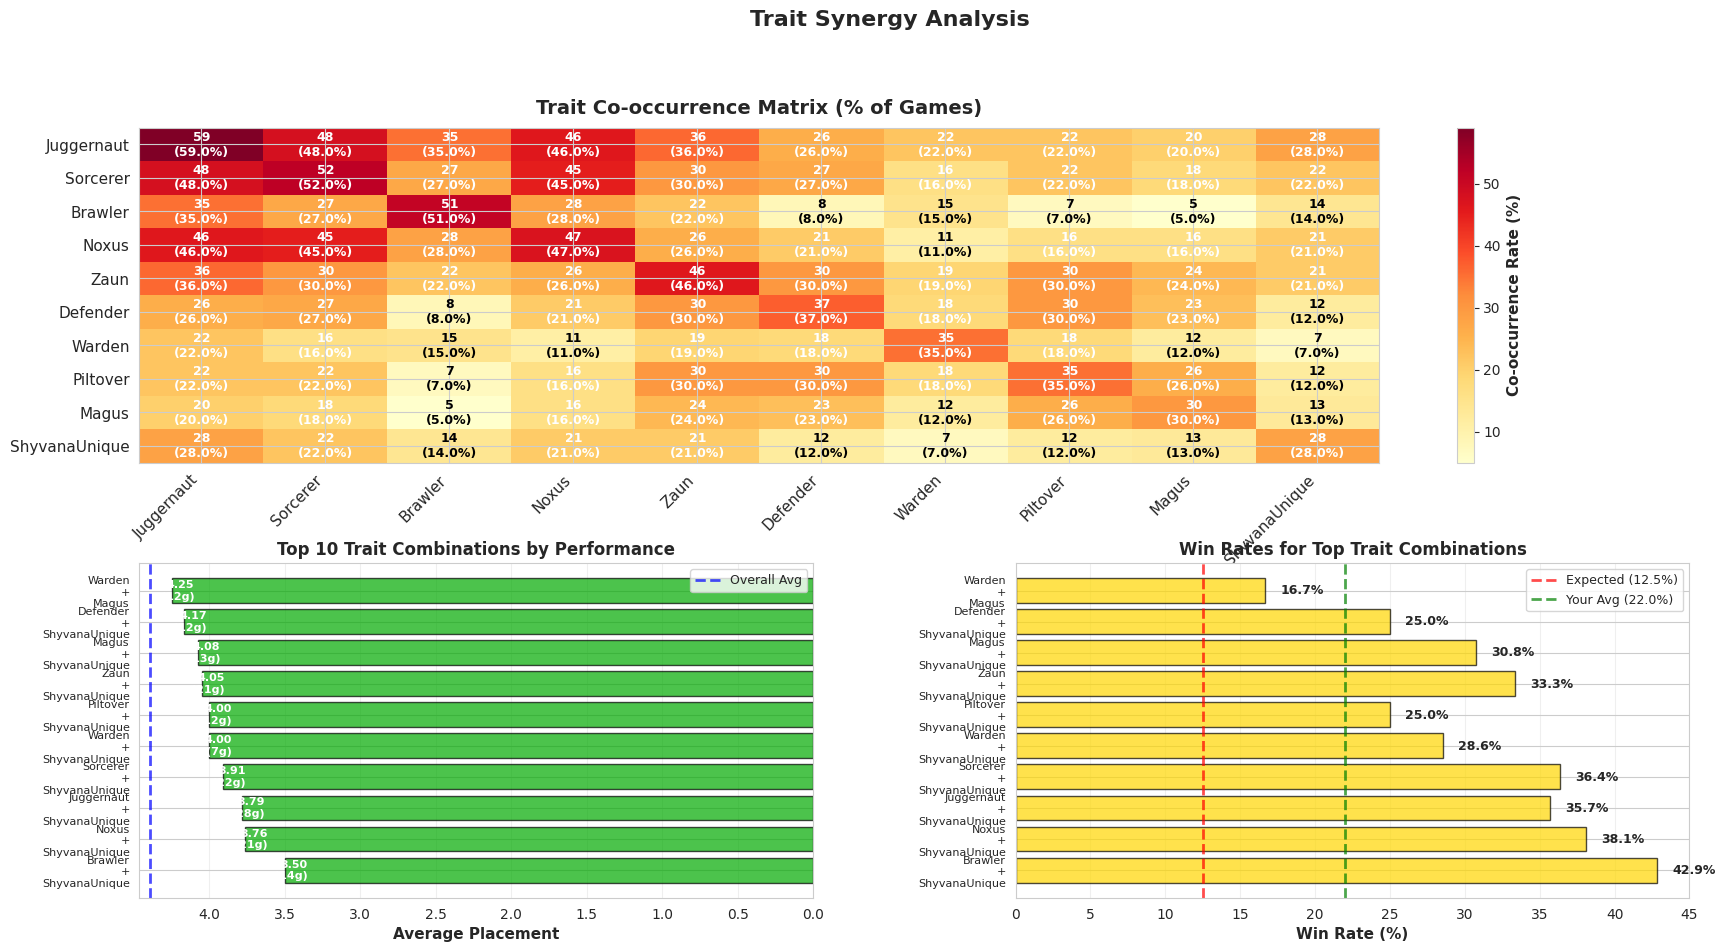

✅ Exported: analysis_trait_synergies.csv



In [51]:
# ===================================================================
# CELL 8: Trait Synergy Network Visualization
# ===================================================================

print("\n" + "="*70)
print("TRAIT SYNERGY AND CO-OCCURRENCE NETWORK")
print("="*70)

# Create trait synergy figure
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# ===================================================================
# 1. Trait Co-occurrence Heatmap (Count-based)
# ===================================================================
ax1 = fig.add_subplot(gs[0, :])

# Normalize co-occurrence matrix for better visualization
trait_matrix_norm = trait_matrix / len(your_games) * 100

im = ax1.imshow(trait_matrix_norm.values, cmap='YlOrRd', aspect='auto')
ax1.set_xticks(range(len(top_10_traits)))
ax1.set_yticks(range(len(top_10_traits)))
ax1.set_xticklabels(top_10_traits, rotation=45, ha='right', fontsize=11)
ax1.set_yticklabels(top_10_traits, fontsize=11)
ax1.set_title('Trait Co-occurrence Matrix (% of Games)', fontsize=14, fontweight='bold', pad=10)

# Add count annotations
for i in range(len(top_10_traits)):
    for j in range(len(top_10_traits)):
        count = trait_matrix.iloc[i, j]
        pct = trait_matrix_norm.iloc[i, j]
        text = ax1.text(j, i, f'{int(count)}\n({pct:.1f}%)',
                       ha="center", va="center",
                       color="white" if pct > 15 else "black",
                       fontsize=9, fontweight='bold')

cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('Co-occurrence Rate (%)', fontsize=11, fontweight='bold')

# ===================================================================
# 2. Top Synergy Combinations Performance
# ===================================================================
ax2 = fig.add_subplot(gs[1, 0])

# Find top co-occurring pairs and their performance
synergy_performance = []
for i, trait1 in enumerate(top_10_traits):
    for trait2 in top_10_traits[i+1:]:
        games_with_both = your_games[
            your_games['trait_list'].apply(lambda x: trait1 in x and trait2 in x)
        ]

        if len(games_with_both) >= 5:
            synergy_performance.append({
                'Combination': f'{trait1}\n+\n{trait2}',
                'Games': len(games_with_both),
                'Avg Placement': games_with_both['placement'].mean(),
                'Win Rate': games_with_both['win'].mean() * 100
            })

synergy_df = pd.DataFrame(synergy_performance).sort_values('Avg Placement').head(10)

colors_syn = ['#00AA00' if x < 4.39 else '#CC0000' for x in synergy_df['Avg Placement']]
bars = ax2.barh(range(len(synergy_df)), synergy_df['Avg Placement'],
                color=colors_syn, edgecolor='black', alpha=0.7)

ax2.set_yticks(range(len(synergy_df)))
ax2.set_yticklabels(synergy_df['Combination'], fontsize=8)
ax2.axvline(4.39, color='blue', linestyle='--', linewidth=2, alpha=0.7,
            label='Overall Avg')
ax2.set_xlabel('Average Placement', fontsize=11, fontweight='bold')
ax2.set_title('Top 10 Trait Combinations by Performance', fontsize=12, fontweight='bold')
ax2.invert_xaxis()
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3, axis='x')

for i, (bar, row) in enumerate(zip(bars, synergy_df.itertuples())):
    ax2.text(row[3] - 0.15, i,
            f'{row[3]:.2f}\n({int(row[2])}g)', # Corrected to use positional indexing
            ha='right', va='center', fontsize=8, fontweight='bold', color='white')

# ===================================================================
# 3. Synergy Win Rates
# ===================================================================
ax3 = fig.add_subplot(gs[1, 1])

bars = ax3.barh(range(len(synergy_df)), synergy_df['Win Rate'],
                color='gold', edgecolor='black', alpha=0.7)

ax3.set_yticks(range(len(synergy_df)))
ax3.set_yticklabels(synergy_df['Combination'], fontsize=8)
ax3.axvline(12.5, color='red', linestyle='--', linewidth=2, alpha=0.7,
            label='Expected (12.5%)')
ax3.axvline(22.0, color='green', linestyle='--', linewidth=2, alpha=0.7,
            label='Your Avg (22.0%)')
ax3.set_xlabel('Win Rate (%)', fontsize=11, fontweight='bold')
ax3.set_title('Win Rates for Top Trait Combinations', fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='x')

for i, (bar, wr) in enumerate(zip(bars, synergy_df['Win Rate'])):
    ax3.text(wr + 1, i, f'{wr:.1f}%',
            ha='left', va='center', fontsize=9, fontweight='bold')

plt.suptitle('Trait Synergy Analysis',
             fontsize=16, fontweight='bold', y=0.998)

plt.savefig('tft_trait_synergies.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: tft_trait_synergies.png")
plt.tight_layout()
plt.show()

# Export synergy data
synergy_df.to_csv('analysis_trait_synergies.csv', index=False)
print("✅ Exported: analysis_trait_synergies.csv")

print("\n" + "="*70)


PERFORMANCE CONSISTENCY AND VARIANCE ANALYSIS

✅ Saved: tft_performance_consistency.png


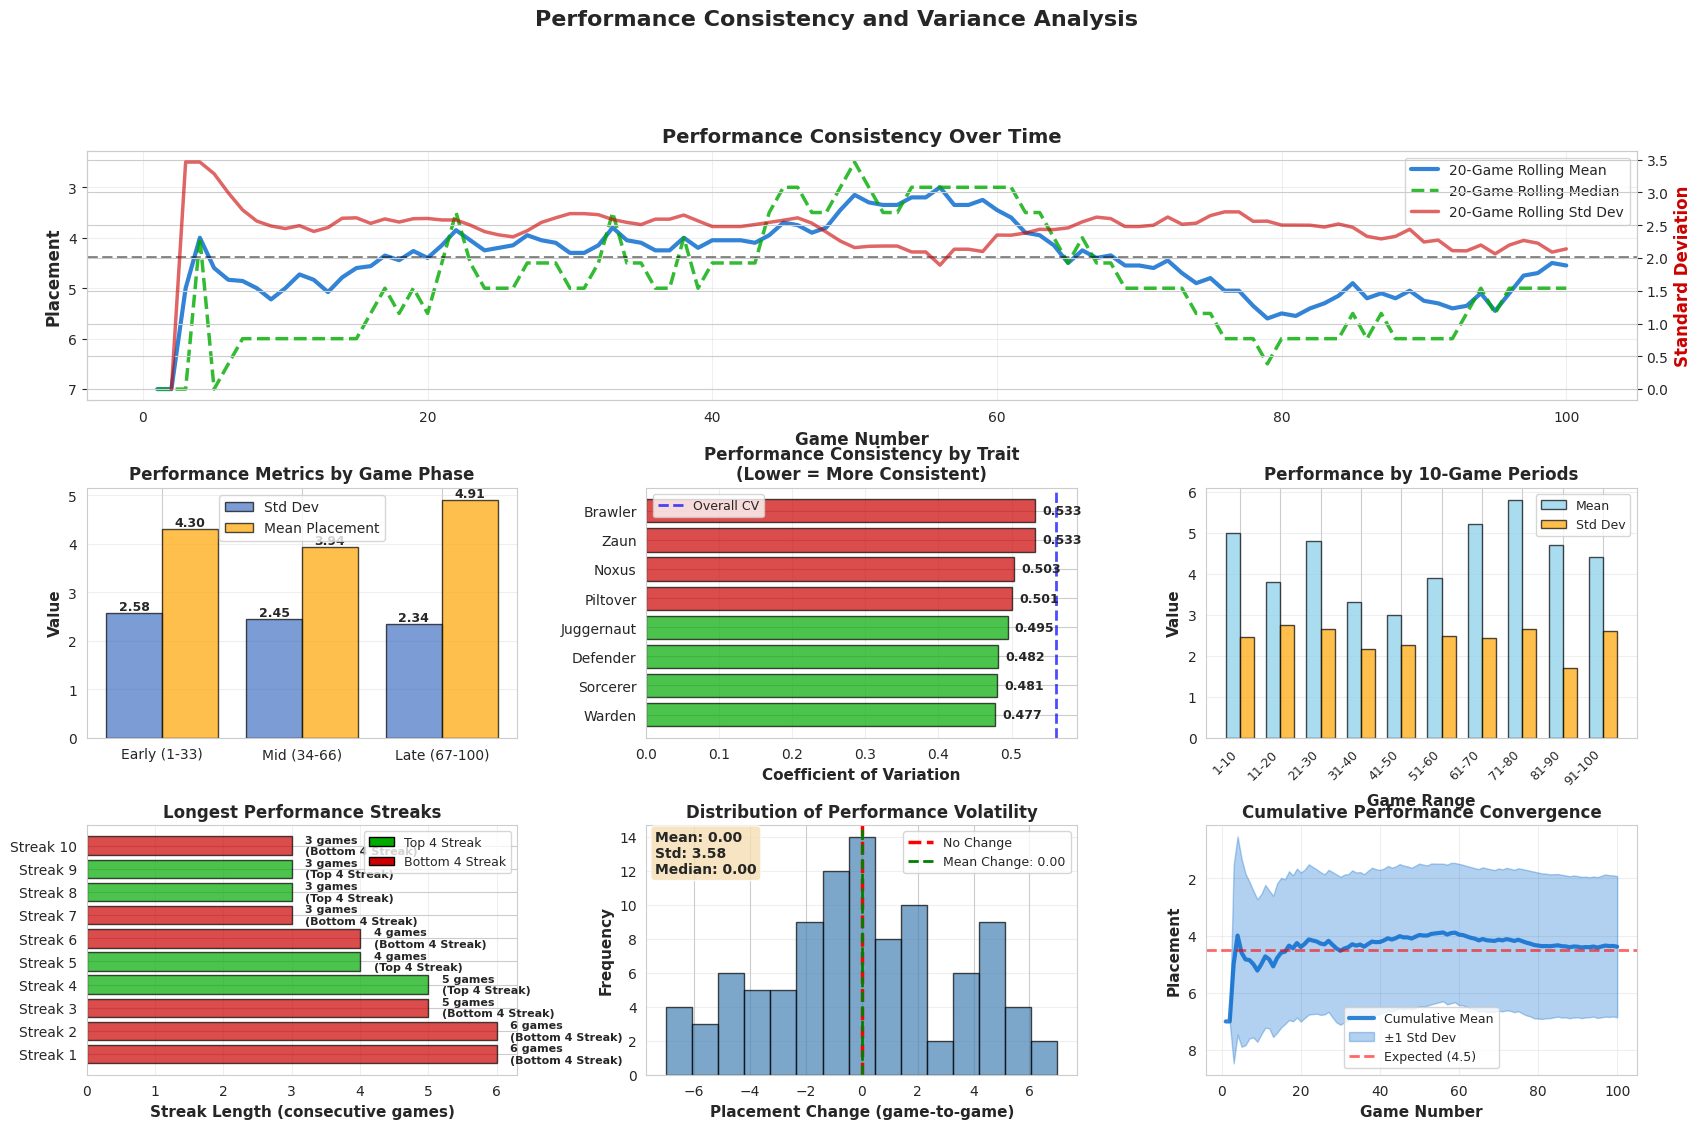


✅ ALL VISUALIZATIONS COMPLETE!

Generated files for IEEE paper:
  1. tft_performance_dashboard.png - Main performance overview
  2. tft_statistical_analysis.png - Mann-Whitney U, effect sizes, correlations
  3. tft_augment_confidence_intervals.png - Wilson CI analysis
  4. tft_trait_synergies.png - Co-occurrence and synergy analysis
  5. tft_performance_consistency.png - Variance and streak analysis

All figures ready for LaTeX \includegraphics{} commands!


In [52]:

# ===================================================================
# CELL 9: Performance Consistency and Variance Analysis
# ===================================================================

print("\n" + "="*70)
print("PERFORMANCE CONSISTENCY AND VARIANCE ANALYSIS")
print("="*70)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# ===================================================================
# 1. Rolling Statistics (Mean, Std Dev, Median)
# ===================================================================
ax1 = fig.add_subplot(gs[0, :])

ax1_twin = ax1.twinx()

# Plot rolling mean and median
ax1.plot(your_games['game_number'], your_games['rolling_avg_20'],
         linewidth=3, color='#0066CC', label='20-Game Rolling Mean', alpha=0.8)
ax1.plot(your_games['game_number'],
         your_games['placement'].rolling(20, min_periods=1).median(),
         linewidth=2.5, color='#00AA00', label='20-Game Rolling Median',
         alpha=0.8, linestyle='--')

# Plot rolling std dev on secondary axis
rolling_std = your_games['placement'].rolling(20, min_periods=1).std()
ax1_twin.plot(your_games['game_number'], rolling_std,
              linewidth=2.5, color='#CC0000', label='20-Game Rolling Std Dev',
              alpha=0.6)

ax1.axhline(4.39, color='black', linestyle='--', linewidth=2, alpha=0.5)
ax1.set_xlabel('Game Number', fontsize=12, fontweight='bold')
ax1.set_ylabel('Placement', fontsize=12, fontweight='bold')
ax1_twin.set_ylabel('Standard Deviation', fontsize=12, fontweight='bold', color='#CC0000')
ax1.set_title('Performance Consistency Over Time', fontsize=14, fontweight='bold')
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

# ===================================================================
# 2. Performance Variance by Phase
# ===================================================================
ax2 = fig.add_subplot(gs[1, 0])

phase_variance = your_games.groupby('phase')['placement'].agg(['mean', 'std', 'var'])
x_pos = np.arange(len(phase_variance))

bars1 = ax2.bar(x_pos - 0.2, phase_variance['std'], 0.4,
                label='Std Dev', color='#4472C4', edgecolor='black', alpha=0.7)
bars2 = ax2.bar(x_pos + 0.2, phase_variance['mean'], 0.4,
                label='Mean Placement', color='#FFA500', edgecolor='black', alpha=0.7)

ax2.set_xticks(x_pos)
ax2.set_xticklabels(phase_variance.index, fontsize=10)
ax2.set_ylabel('Value', fontsize=11, fontweight='bold')
ax2.set_title('Performance Metrics by Game Phase', fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom',
                fontsize=9, fontweight='bold')

# ===================================================================
# 3. Coefficient of Variation by Trait
# ===================================================================
ax3 = fig.add_subplot(gs[1, 1])

trait_cv = []
for trait in top_10_traits[:8]:
    games_with = your_games[your_games['trait_list'].apply(lambda x: trait in x)]
    if len(games_with) >= 10:
        cv = games_with['placement'].std() / games_with['placement'].mean()
        trait_cv.append({'Trait': trait, 'CV': cv, 'Games': len(games_with)})

trait_cv_df = pd.DataFrame(trait_cv).sort_values('CV')

colors_cv = ['#00AA00' if cv < 0.5 else '#CC0000' for cv in trait_cv_df['CV']]
bars = ax3.barh(trait_cv_df['Trait'], trait_cv_df['CV'],
                color=colors_cv, edgecolor='black', alpha=0.7)

ax3.axvline(your_games['placement'].std() / your_games['placement'].mean(),
            color='blue', linestyle='--', linewidth=2, alpha=0.7,
            label='Overall CV')
ax3.set_xlabel('Coefficient of Variation', fontsize=11, fontweight='bold')
ax3.set_title('Performance Consistency by Trait\n(Lower = More Consistent)',
              fontsize=12, fontweight='bold')
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, trait_cv_df['CV']):
    ax3.text(val + 0.01, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')

# ===================================================================
# 4. Placement Variance Heatmap (By Week/Period)
# ===================================================================
ax4 = fig.add_subplot(gs[1, 2])

# Create 10-game periods
your_games['period'] = (your_games['game_number'] - 1) // 10
period_stats = your_games.groupby('period')['placement'].agg(['mean', 'std'])

periods = period_stats.index.values
x_pos = np.arange(len(periods))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, period_stats['mean'], width,
                label='Mean', color='skyblue', edgecolor='black', alpha=0.7)
bars2 = ax4.bar(x_pos + width/2, period_stats['std'], width,
                label='Std Dev', color='orange', edgecolor='black', alpha=0.7)

ax4.set_xticks(x_pos)
ax4.set_xticklabels([f'{i*10+1}-{(i+1)*10}' for i in periods],
                     rotation=45, ha='right', fontsize=9)
ax4.set_xlabel('Game Range', fontsize=11, fontweight='bold')
ax4.set_ylabel('Value', fontsize=11, fontweight='bold')
ax4.set_title('Performance by 10-Game Periods', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3, axis='y')

# ===================================================================
# 5. Win Streak / Loss Streak Analysis
# ===================================================================
ax5 = fig.add_subplot(gs[2, 0])

# Calculate streaks
your_games['top4'] = (your_games['placement'] <= 4).astype(int)
your_games['streak'] = (your_games['top4'] != your_games['top4'].shift()).cumsum()
streaks = your_games.groupby('streak')['top4'].agg(['first', 'count'])
streaks['type'] = streaks['first'].map({1: 'Top 4 Streak', 0: 'Bottom 4 Streak'})

# Get top streaks
top_streaks = streaks.nlargest(10, 'count')
colors_streak = ['#00AA00' if t == 'Top 4 Streak' else '#CC0000'
                 for t in top_streaks['type']]

bars = ax5.barh(range(len(top_streaks)), top_streaks['count'],
                color=colors_streak, edgecolor='black', alpha=0.7)

ax5.set_yticks(range(len(top_streaks)))
ax5.set_yticklabels([f"Streak {i+1}" for i in range(len(top_streaks))], fontsize=10)
ax5.set_xlabel('Streak Length (consecutive games)', fontsize=11, fontweight='bold')
ax5.set_title('Longest Performance Streaks', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3, axis='x')

# Add legend manually
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#00AA00', edgecolor='black', label='Top 4 Streak'),
                   Patch(facecolor='#CC0000', edgecolor='black', label='Bottom 4 Streak')]
ax5.legend(handles=legend_elements, fontsize=9)

for i, (bar, val, streak_type) in enumerate(zip(bars, top_streaks['count'], top_streaks['type'])):
    ax5.text(val + 0.2, i, f'{val} games\n({streak_type})',
            ha='left', va='center', fontsize=8, fontweight='bold')

# ===================================================================
# 6. Distribution of Placement Differences (Game-to-Game Change)
# ===================================================================
ax6 = fig.add_subplot(gs[2, 1])

placement_diff = your_games['placement'].diff().dropna()
ax6.hist(placement_diff, bins=15, color='steelblue', edgecolor='black', alpha=0.7)
ax6.axvline(0, color='red', linestyle='--', linewidth=2.5, label='No Change')
ax6.axvline(placement_diff.mean(), color='green', linestyle='--', linewidth=2,
            label=f'Mean Change: {placement_diff.mean():.2f}')

ax6.set_xlabel('Placement Change (game-to-game)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax6.set_title('Distribution of Performance Volatility', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3, axis='y')

# Add statistics text
stats_text = f"Mean: {placement_diff.mean():.2f}\nStd: {placement_diff.std():.2f}\nMedian: {placement_diff.median():.2f}"
ax6.text(0.02, 0.98, stats_text, transform=ax6.transAxes,
         fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         verticalalignment='top')

# ===================================================================
# 7. Cumulative Performance Metrics
# ===================================================================
ax7 = fig.add_subplot(gs[2, 2])

cumulative_avg = your_games['placement'].expanding().mean()
cumulative_std = your_games['placement'].expanding().std()

ax7.plot(your_games['game_number'], cumulative_avg,
         linewidth=3, color='#0066CC', label='Cumulative Mean', alpha=0.8)
ax7.fill_between(your_games['game_number'],
                 cumulative_avg - cumulative_std,
                 cumulative_avg + cumulative_std,
                 alpha=0.3, color='#0066CC', label='±1 Std Dev')

ax7.axhline(4.5, color='red', linestyle='--', linewidth=2, alpha=0.6,
            label='Expected (4.5)')
ax7.set_xlabel('Game Number', fontsize=11, fontweight='bold')
ax7.set_ylabel('Placement', fontsize=11, fontweight='bold')
ax7.set_title('Cumulative Performance Convergence', fontsize=12, fontweight='bold')
ax7.legend(fontsize=9)
ax7.invert_yaxis()
ax7.grid(True, alpha=0.3)

plt.suptitle('Performance Consistency and Variance Analysis',
             fontsize=16, fontweight='bold', y=0.998)

plt.savefig('tft_performance_consistency.png', dpi=300, bbox_inches='tight')
print("\n✅ Saved: tft_performance_consistency.png")
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✅ ALL VISUALIZATIONS COMPLETE!")
print("="*70)
print("\nGenerated files for IEEE paper:")
print("  1. tft_performance_dashboard.png - Main performance overview")
print("  2. tft_statistical_analysis.png - Mann-Whitney U, effect sizes, correlations")
print("  3. tft_augment_confidence_intervals.png - Wilson CI analysis")
print("  4. tft_trait_synergies.png - Co-occurrence and synergy analysis")
print("  5. tft_performance_consistency.png - Variance and streak analysis")
print("\nAll figures ready for LaTeX \\includegraphics{} commands!")
print("="*70)